# Apartment search using ORS and Ohsome API 


In this notebook, we will perform a search for a new apartment in Hamburg based on the surrounding amenities. In addition to popular python packages for geospatial data processing such as `geopandas` we will also use the openrouteservice and ohsome APIs.  

**Execute each cell one by one first** to see how it works by clicking **the `Run` button** in the menu above or **pressing `Shift` + `Enter`** on your keyboard. Afterwards, go through the notebook again and change some of paramters in the cell where it says "**Exercise**" and execute the following cells to run the analysis with different parameters.

## Some required Python Basics

Before we get started, there are some basics in python that you need to understand. In Python there are variables or objects which can hold different types of values. 

**Numbers** 

In [1]:
x = 5
y = 4.2

In [2]:
x

5

In [3]:
y

4.2

**Characters**

In [4]:
x = "hello"

In [5]:
x

'hello'

**Lists**

In [6]:
l = [1,2,6]

In [7]:
l

[1, 2, 6]

**Dictionaries** consisting of key-value pairs

In [8]:
d = {"key": "value"}

In [9]:
d

{'key': 'value'}

In [10]:
d2 = {"name": "Mona-Lisa", 
     "age": 516}

In [11]:
d2

{'name': 'Mona-Lisa', 'age': 516}

**Functions:**  Functions are used to perform operations on the data. 

In [12]:
x = 5
y = 7
sum([x,y])

12

Python contains some built-in functions such as `sum()`, but they are limited. You can import additional functions from packages. These are the ones that we need for our analysis:

In [36]:
"""These are just some imports, which means loading additional functionalities in Python. We have to import these so-called
libraries so we can execute the code below."""

from ipyleaflet import Map, Marker, GeoData, basemaps,ScaleControl, LayersControl, GeoJSON, LegendControl
from ipywidgets import Layout
import json
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

## Create a list of potential apartments

We store the locations of three potential apartments which we may have found online in a dictionary with geographic coordinates.

**Exercise:** Change the coordinates of the locations or add additinal ones to the dictionary and run the analysis again.  

In [37]:
apartments = {'0': {'location': [9.981727, 53.552018]}, # longitude, latitude
              '1': {'location': [9.921727, 53.552018]},
              '2': {'location': [9.981727, 53.572018]}}

Let's convert it into a table.

In [38]:
apartments_df = gpd.GeoDataFrame().from_dict(apartments, orient="index")
apartments_df["geometry"] = apartments_df.location.map(lambda x: Point(x[0], x[1]))

In [39]:
apartments_df

,location,geometry
0,"[9.981727, 53.552018]",POINT (9.98173 53.55202)
1,"[9.921727, 53.552018]",POINT (9.92173 53.55202)
2,"[9.981727, 53.572018]",POINT (9.98173 53.57202)


### Map of apartments

In [40]:
# Create map with basemap
map_center = list(apartments_df.dissolve().centroid[0].coords)[0]
m = Map(center=map_center[::-1], zoom=13, scroll_wheel_zoom=True, basemap=basemaps.CartoDB.Positron)

# Add appartments as points
apartment_layer = GeoData(geo_dataframe = apartments_df,
    style={'color': 'black', 
           'radius':8, 
           'fillColor': '#3366cc', 
           'opacity':0.5, 
           'weight':1.9, 
           'dashArray':'2', 
           'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 
                 'fillOpacity': 0.2},
    point_style={'radius': 5, 
                 'color': 'red', 
                 'fillOpacity': 0.8, 
                 'fillColor': 'blue', 
                 'weight': 3},
    name = 'Apartments')
m.add_layer(apartment_layer)

# Add a scale to map 
m.add_control(ScaleControl(position='bottomleft'))
# Add layer control 
control = LayersControl(position='topright')
m.add_control(control)

display(m)

Map(center=[53.558684666666664, 9.961727], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

## Count number of restaurants nearby each apartment

Let's assume it is very important to you that you have many restaurants within a short walk of your apartment. So we will count how many restaurants are within a 10 minutes walking time of each apartment. There are two steps: 

1. Calculate the area within 10 minutes walking time around each apartment using openrouteservice isochrones
2. Downloading and counting the restaurants from OpenStreetMap using the ohsome API. 

### 1. Create isochrones around each apartment

First, we will request the isochrones around each apartment and visualize them in the map. For details about the parameters see the [ORS documentation](https://openrouteservice.org/dev/#/api-docs/isochrones). Play around with the settings to find out what each variable is for.

In order to use the OpenRouteSerive API, you need to [create an account and generate a free API key](https://openrouteservice.org/dev/#/login). You can use your github account for it.

In [41]:
from openrouteservice import client

In [42]:
ors_api_key = '5b3ce3597851110001cf6248eef794d1244544f7826f417356aee9e4' #Replace this with your own personal ORS API key

In [43]:
ors_client = client.Client(key=ors_api_key) 

**Exercise:** Switch the routing profile to cycling by replacing `foot-walking` with `cycling-regular` and reduce the range of the isochrones to 5 minutes. Then run the cells below again to create new isochrones.

In [44]:
ors_settings = {'profile': 'foot-walking', # ORS routing profile
              'range': [600], # Max range of isochrones in sec if range_type=time
              'range_type':  'time', # Type of isochones: time or distance
              'attributes': ['area'], # Get area of each isochrone
              'locations' : list(apartments_df.location)
             }

In [45]:
isochrones = ors_client.isochrones(**ors_settings) 

**Calculate the area of the isochrones**

How big is the area that we can reach from our potential apartments within a 10 minute walk? To find out, we first create a dataframe from the isochrones layer.

In [46]:
isochones_df = gpd.GeoDataFrame.from_features(isochrones['features'], crs="epsg:4326")

The coordinate system of the isochrones dataframe is WGS 84. We can get more information on the coordinate system the following way:

In [47]:
isochones_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The unit of the coordinates is degree, so to be able to calculate the area, we first have to reproject the isochrones to a projected coordinate system. Let's reprojetc them to UTM zone 32N.

In [48]:
isochrones_projected = isochones_df.to_crs(epsg=25832)
isochrones_projected.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Now, we can simply calculate the area of the isochrones and save it in a new column in the dataframe.

In [49]:
isochrones_projected["area [km²]"] = (isochrones_projected.area/1000000).round(2)
isochrones_projected

,geometry,group_index,value,center,area,area [km²]
0,"POLYGON ((564364.969 5934020.572, 564392.857 5...",0,600.0,"[9.98175290826924, 53.55215598915689]",1423431.84,1.43
1,"POLYGON ((560314.082 5933953.591, 560408.661 5...",1,600.0,"[9.921641683317162, 53.55202787113252]",1301684.70,1.30
2,"POLYGON ((564374.106 5935948.308, 564384.864 5...",2,600.0,"[9.981587050051512, 53.57205631007921]",1503191.38,1.51


Oh look, the area was already saved in the isochrones dataframe. So we can see that our calculated area is correct.

#### Map with apartments and isochrones

In [50]:
# Create map with basemap (available basemaps: https://ipyleaflet.readthedocs.io/en/latest/map_and_basemaps/basemaps.html)
m = Map(center=map_center[::-1], zoom=13, scroll_wheel_zoom=True, basemap=basemaps.CartoDB.Positron)

# Add isochrones 
isochones_layer = GeoJSON(
    data=isochrones,
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    })
m.add_layer(isochones_layer)

# Add appartments as points
apartment_layer = GeoData(geo_dataframe = apartments_df,
    style={'color': 'black', 
           'radius':8, 
           'fillColor': '#3366cc', 
           'opacity':0.5, 
           'weight':1.9, 
           'dashArray':'2', 
           'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 
                 'fillOpacity': 0.2},
    point_style={'radius': 5, 
                 'color': 'red', 
                 'fillOpacity': 0.8, 
                 'fillColor': 'blue', 
                 'weight': 3},
    name = 'Apartments')
m.add_layer(apartment_layer)

# Add a scale to map 
m.add_control(ScaleControl(position='bottomleft'))

control = LayersControl(position='topright')
m.add_control(control)

display(m)

Map(center=[53.558684666666664, 9.961727], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

## 2. Number of restaurants nearby apartments using Ohsome API
Now that we created the isochrones, we want to know how many restaurants there are in the neighbourhood. For this purpose, we will use the Ohsome API. 

In [51]:
import ohsome
ohsome_client = ohsome.OhsomeClient()

### 2.1. Download restaurants as features to visualize them on the map

**Exercise:** Set a different tag in the the `osm_filter`. 

In [52]:
osm_filer = "amenity=restaurant"

Now, we use a post request in Ohsome to download the restaurants within our isochrones from OSM. We save the restaurants in a dataframe called `restaurants_df`.

In [53]:
restaurant_features = ohsome_client.elements.centroid.post(bpolys=json.dumps(isochrones),
                                                           properties="tags",
                                                             filter=osm_filer)
restaurants_df = restaurant_features.as_dataframe()

How do the data look?

In [54]:
restaurants_df.head()

,,geometry,addr:country,addr:housename,addr:housenumber,addr:postcode,addr:street,air_conditioning,alt_name,amenity,architect,...,opening_hours:kitchen,entrance,dine_in,addr:suburb,bettundbike,organic,tourism,diet:gluten_free,source,fixme
@osmId,@snapshotTimestamp,,,,,,,,,,,,,,,,,,,,,
node/10073919677,2023-01-29 21:00:00,POINT (9.98019 53.56867),NaN,NaN,NaN,NaN,NaN,NaN,NaN,restaurant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
node/10106658736,2023-01-29 21:00:00,POINT (9.99079 53.55062),NaN,NaN,NaN,NaN,NaN,NaN,NaN,restaurant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
node/10121414284,2023-01-29 21:00:00,POINT (9.98746 53.55304),NaN,NaN,10,NaN,Hohe Bleichen,NaN,NaN,restaurant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
node/10269219209,2023-01-29 21:00:00,POINT (9.98314 53.57047),NaN,NaN,34,NaN,Rutschbahn,NaN,NaN,restaurant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
node/10316530231,2023-01-29 21:00:00,POINT (9.99051 53.55520),NaN,NaN,NaN,NaN,NaN,NaN,NaN,restaurant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2. Intersect isochrones with restaurants and count them

We intersect the dataframe `isochrones_df` that we have created earlier with the dataframe `restaurants_df` containing the restaurants, hereby counting the restaurants in each isochrone. The number of restaurants in each isochrone is then saved in the dataframe `apartments_df`.

In [55]:
isochrone_restaurants = gpd.sjoin(restaurants_df, isochones_df, how="left").groupby("group_index").count()
apartments_df["restaurants"] = list(isochrone_restaurants["amenity"])

In [56]:
apartments_df

,location,geometry,restaurants
0,"[9.981727, 53.552018]",POINT (9.98173 53.55202),92
1,"[9.921727, 53.552018]",POINT (9.92173 53.55202),41
2,"[9.981727, 53.572018]",POINT (9.98173 53.57202),50


### Alternative:  Count number of restaurants within isochrones using ohsome API

Alternatively, we could have calculated the number of restauratans within in each isochrone also using the ohsome API directly without downloading the restaurant features. 

In [57]:
response = ohsome_client.elements.count.groupByBoundary.post(bpolys=json.dumps(isochrones),
                                                             filter="amenity=restaurant")
restaurants = response.as_dataframe()["value"]
apartments_df["restaurants_ohsome"] = list(restaurants)

In [58]:
apartments_df

,location,geometry,restaurants,restaurants_ohsome
0,"[9.981727, 53.552018]",POINT (9.98173 53.55202),92,92.0
1,"[9.921727, 53.552018]",POINT (9.92173 53.55202),41,41.0
2,"[9.981727, 53.572018]",POINT (9.98173 53.57202),50,50.0


### Map with apartments and restaurants using ipyleaflet basemap

**Exercise:** You may adapt the style of the final map by changing some of the parameters, e.g. the color or radius of the points in the dictionary, e.g. set `'radius':5`. You may also change the basemap by replacing the value of `basemap=basemaps.CartoDB.Positron` in the first two lines e.g. set it to `basemap=basemaps.OpenStreetMap.Mapnik`. Refer to the documentation for [available basemaps](https://ipyleaflet.readthedocs.io/en/latest/map_and_basemaps/basemaps.html).

In [59]:
# Create map with basemap (available basemaps: https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html)
m = Map(center=map_center[::-1], zoom=13, scroll_wheel_zoom=True, layout=Layout(width='100%', height='500px'),
        basemap=basemaps.CartoDB.Positron)

# Add isochrones 
isochones_layer = GeoJSON(
    data=isochrones,
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1, 'fillColor': '#1166cc'
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    })
m.add_layer(isochones_layer)

# Add apartments as points
apartment_layer = GeoData(geo_dataframe = apartments_df,
    style={'color': 'black', 
           'radius':8, 
           'fillColor': '#3366cc', 
           'opacity':0.5, 
           'weight':1.9, 
           'dashArray':'2', 
           'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 
                 'fillOpacity': 0.2},
    point_style={'radius': 5, 
                 'color': 'red', 
                 'fillOpacity': 0.8, 
                 'fillColor': 'blue', 
                 'weight': 3},
    name = 'Apartments')
m.add_layer(apartment_layer)

# Add restaurants as points
restaurants_layer = GeoData(geo_dataframe = restaurants_df,
    style={'color': 'black', 
           'radius':4, 
           'fillColor': 'red', 
           'opacity':0.5, 
           'weight':1.9, 
           'dashArray':'2', 
           'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 
                 'fillOpacity': 0.2},
    point_style={'radius': 5, 
                 'color': 'red', 
                 'fillOpacity': 0.8, 
                 'fillColor': 'blue', 
                 'weight': 3},
    name = 'Restaurants')

m.add_layer(restaurants_layer)

# Add a scale to map 
m.add_control(ScaleControl(position='bottomleft'))

control = LayersControl(position='topright')
m.add_control(control)

# Add legend
legend = LegendControl({"Apartments":"#3366cc", 
                        "Restaurants":"red", 
                        "Isochrones [10 min]":"#c5e8ef"}, name="Legend", position="bottomright")
m.add_control(legend)

display(m)

Map(center=[53.558684666666664, 9.961727], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

### Alternative: Map with apartments and restaurants using contextily

**Exercise:** Here, you may also adapt the style of the final map by changing some of the parameters, e.g. the color or radius of the points, e.g. set `markersize=100`. You may also change the basemap by replacing the value of `source=ctx.providers.Stamen.Terrain` in the last line, e.g. set it to `source=ctx.providers.OpenStreetMap.Mapnik`. Refer to the documentation for [available basemaps](https://contextily.readthedocs.io/en/latest/intro_guide.html#Providers).

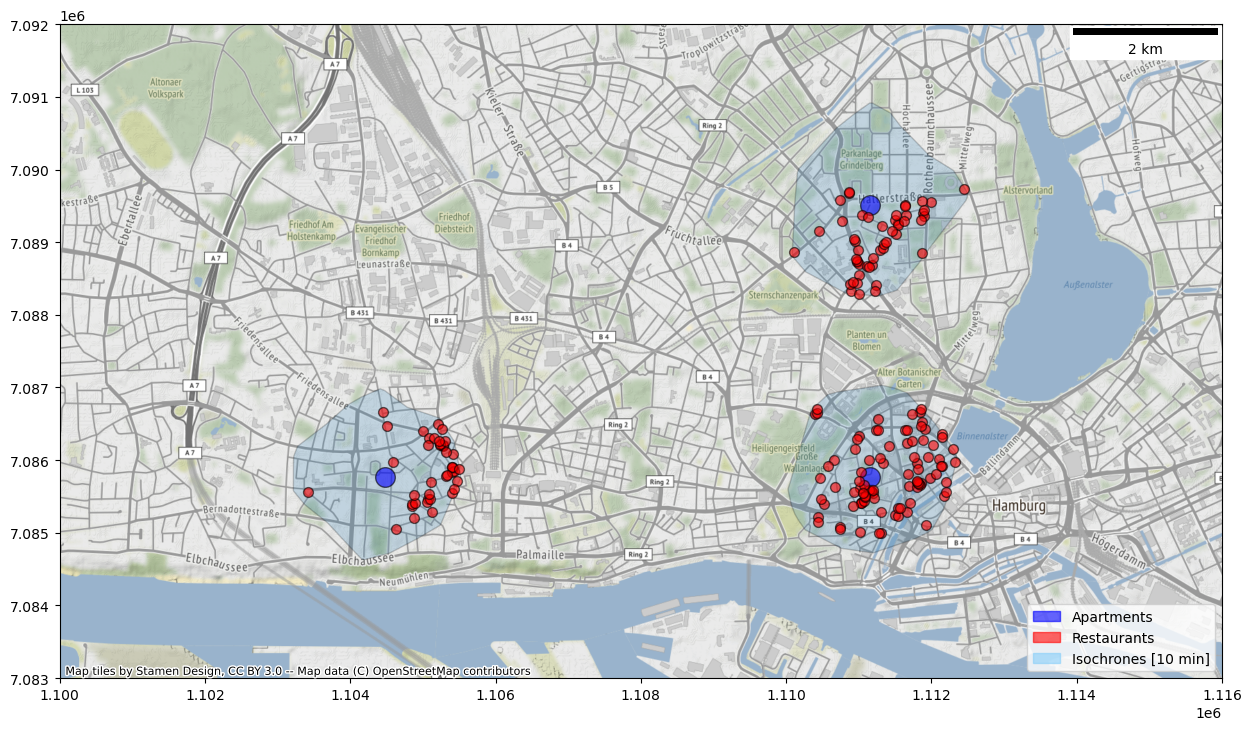

In [60]:
# Set CRS of dataframes
apartments_df = apartments_df.set_crs('epsg:4326')
restaurants_df = restaurants_df.set_crs('epsg:4326')

# Reproject dataframes to web mercator
isochones_wm = isochones_df.to_crs(epsg=3857)
apartments_wm = apartments_df.to_crs(epsg=3857)
restaurants_wm = restaurants_df.to_crs(epsg=3857)

# Create map
ax = isochones_wm.plot(figsize=(15, 15), alpha=0.2, edgecolor='k')
apartments_wm.plot(ax=ax, alpha=0.6, color='blue', edgecolor='k', markersize=200)
restaurants_wm.plot(ax=ax, alpha=0.6, color='red', edgecolor='k', markersize=50)

# Set map extent
xlim = ([1100000, 1116000])
ylim = ([7083000, 7092000])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Add legend
blue_patch = mpatches.Patch(color='blue', alpha=0.6, label='Apartments')
red_patch = mpatches.Patch(color='red', alpha=0.6, label='Restaurants')
lb_patch = mpatches.Patch(color='lightskyblue', alpha=0.6, label='Isochrones [10 min]')
ax.legend(handles=[blue_patch, red_patch, lb_patch], loc='lower right')

# Add scale bar
ax.add_artist(ScaleBar(1))

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain)